# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import tensorflow as tf
from tqdm import tqdm_notebook

# Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# загрузим данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape, y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(40000, 32, 32, 3) (40000, 1)


In [ ]:
# наши классы
class_names

array(['airplane', 'automobile ', 'bird ', 'cat ', 'deer ', 'dog ',
       'frog ', 'horse ', 'ship ', 'truck'], dtype='<U11')

Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

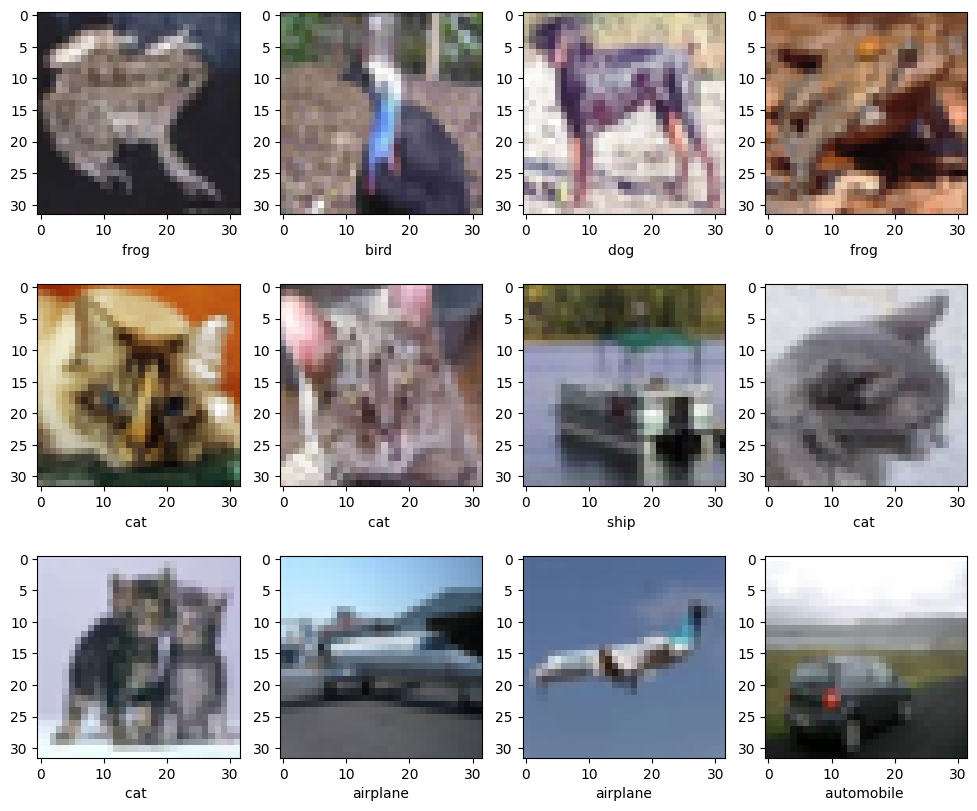

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

In [ ]:
# проверим сбалансированность классов
from collections import Counter, OrderedDict

flatList = [element for innerList in y_train for element in innerList]
print(Counter(flatList))
# отсортируем
print(OrderedDict(sorted(Counter(flatList).items(), key=lambda _: _[0])))

Counter({4: 4067, 0: 4027, 1: 4021, 7: 4006, 6: 4004, 5: 3985, 8: 3983, 3: 3977, 2: 3970, 9: 3960})
OrderedDict([(0, 4027), (1, 4021), (2, 3970), (3, 3977), (4, 4067), (5, 3985), (6, 4004), (7, 4006), (8, 3983), (9, 3960)])


In [ ]:
print('Уникальными элементами являются- ', np.unique(y_train))
print('Количество уникальных элементов- ', len(np.unique(y_train)))

Уникальными элементами являются-  [0 1 2 3 4 5 6 7 8 9]
Количество уникальных элементов-  10


#ResNet50

In [ ]:
# https://keras.io/api/applications/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers, models


In [ ]:
# Загрузим и настроим предобученную сеть ResNet50

imported_model= tf.keras.applications.ResNet50(include_top=False,
                input_shape=(32,32,3),
                pooling='avg',
                classes=10,
                weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

In [ ]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.00001,
                                        cooldown=2,
                                        min_lr=1e-5
                                       )

In [ ]:
# построим модель
# Создание предобученной модели на основе ResNet50
try:
  K.clear_session()
  del model_RN50
except:
  pass

model_RN50 = Sequential(name='ResNet50')
model_RN50.add(imported_model)

# Добавление полносвязных слоев
model_RN50.add(layers.Flatten())
model_RN50.add(layers.Dense(128, activation='relu'))
model_RN50.add(layers.Dropout(0.2))
model_RN50.add(layers.BatchNormalization())
model_RN50.add(layers.Dense(128, activation='relu'))
model_RN50.add(layers.Dropout(0.2))
model_RN50.add(layers.BatchNormalization())
model_RN50.add(layers.Dense(10, activation='softmax'))


In [ ]:
model_RN50.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,868,810 (91.05 MB)

 Trainable params: 280,586 (1.07 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [ ]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 50
learning_rate = 0.00075
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model_RN50.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model_RN50.fit(X_train, y_train,
               batch_size=32,
               epochs=epochs,
               #callbacks=None,
               callbacks=[reduce_lr],
               validation_split=0.2
)

#0
# Dropout + BatchNormalization

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 165ms/step - loss: 2.5441 - sparse_categorical_accuracy: 0.1339 - val_loss: 2.3787 - val_sparse_categorical_accuracy: 0.1125 - learning_rate: 7.5000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 173s 173ms/step - loss: 2.1083 - sparse_categorical_accuracy: 0.1961 - val_loss: 2.8869 - val_sparse_categorical_accuracy: 0.1103 - learning_rate: 7.5000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 202s 174ms/step - loss: 2.0252 - sparse_categorical_accuracy: 0.2248 - val_loss: 1.9716 - val_sparse_categorical_accuracy: 0.2377 - learning_rate: 7.5000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 201s 173ms/step - loss: 1.9966 - sparse_categorical_accuracy: 0.2295 - val_loss: 2.2758 - val_sparse_categorical_accuracy: 0.1579 - learning_rate: 7.5000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 1.9888 - sparse_categorical_accuracy: 0.2371
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
1000/1000 ━━━━━

KeyboardInterrupt: 

#Построим свою НС

In [ ]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [ ]:
!pip install tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs '/content/sample_data'

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-12-22 08:13:00.661319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 08:13:00.702963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 08:13:00.715685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 08:13:02.973620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

In [ ]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.00001,
                                        cooldown=2,
                                        min_lr=1e-5
                                       )

In [ ]:
# построим нашу модель
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(32, 32, 3))

# зададим 1-ю цепочку сверточных слоев
way_1 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='same')(way_1)
way_1 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(way_1)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='same')(way_1)

# зададим 2-ю цепочку сверточных слоев
way_2 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_2 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='same')(way_2)
way_2 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(way_2)
way_2 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='same')(way_2)

# зададим 3-ю цепочку сверточных слоев
way_3 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)
way_3 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(way_3)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)

# зададим 4-ю цепочку сверточных слоев
way_4 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)
way_4 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(way_4)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)

# объединим
merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.Flatten()(merged)

# добавим полносвязные слои
out = L.Dense(64, activation='relu')(merged)
out = L.Dropout(0.1)(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_model')

In [ ]:
model.summary()

Model: "My_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 32)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 16, 16, 32)     │              0 │ conv2d_4[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 16, 16, 32)     │              0 │ conv2d_6[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 64)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 8, 8, 64)       │              0 │ conv2d_5[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├──────────────────────

 Total params: 1,129,002 (4.31 MB)

 Trainable params: 1,128,810 (4.31 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

InvocationException: Program terminated with status: -6. stderr follows: failed at node 854[1]
dot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.


In [ ]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(X_train, y_train,
          batch_size=32,
          epochs=epochs,
          #callbacks=None,
          callbacks=[reduce_lr],
          validation_split=0.2
)

Epoch 1/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 230s 225ms/step - loss: 1.8804 - sparse_categorical_accuracy: 0.3272 - val_loss: 1.5198 - val_sparse_categorical_accuracy: 0.4762 - learning_rate: 0.0010
Epoch 2/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 215s 215ms/step - loss: 1.2797 - sparse_categorical_accuracy: 0.5434 - val_loss: 1.0624 - val_sparse_categorical_accuracy: 0.6330 - learning_rate: 0.0010
Epoch 3/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 259s 212ms/step - loss: 1.0590 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.1322 - val_sparse_categorical_accuracy: 0.6135 - learning_rate: 0.0010
Epoch 4/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.9460 - sparse_categorical_accuracy: 0.6665
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 264s 214ms/step - loss: 0.9460 - sparse_categorical_accuracy: 0.6665 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.6185 - learning_rate: 0.0010
Epoch 5/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 

#Попробум преобразовать целевые переменные в катерорийные признаки

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0,
                                        cooldown=3,
                                        min_lr=1e-5
                                       )

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             reduce_lr
             # tf.keras.callbacks.EarlyStopping(patience=3)
            ]

In [ ]:
## TODO
#model.compile(...)
#model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=callbacks, validation_split=0.2)

In [ ]:
K.clear_session()
# удаление модели
del model

In [ ]:
# зададим параметры оптимизатора
sgd = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

In [ ]:
# построим модель
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │       1,048,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,050,122 (4.01 MB)

 Trainable params: 1,050,122 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# скомпилируем модель
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy']
             )

# обучим модель
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=32,
          callbacks=[callbacks],
          validation_split=0.2
         )

Epoch 1/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.2688 - loss: 1.9801 - val_accuracy: 0.4060 - val_loss: 1.6691 - learning_rate: 0.0050
Epoch 2/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4084 - loss: 1.6499 - val_accuracy: 0.4296 - val_loss: 1.6177 - learning_rate: 0.0050
Epoch 3/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.4464 - loss: 1.5497 - val_accuracy: 0.4484 - val_loss: 1.5736 - learning_rate: 0.0050
Epoch 4/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.4735 - loss: 1.4800 - val_accuracy: 0.4663 - val_loss: 1.5048 - learning_rate: 0.0050
Epoch 5/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.4913 - loss: 1.4311 - val_accuracy: 0.4751 - val_loss: 1.4827 - learning_rate: 0.0050
Epoch 6/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5137 - loss: 1.3768 - val_accuracy: 0.4890 - val_loss: 1.4500 - learning_rate: 0.0050
Epoch 7/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accura

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 Test_acc = 0.4795
 Not bad!


# Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
## TODO
#new_model = tf.keras.models.Sequential([...])

In [ ]:
K.clear_session()
# удаление модели
del new_model

In [ ]:
# построим модель
new_model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                      padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
                                        ]
                                       )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# посмотрим на модель
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 10)          │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         256,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,390 (1005.43 KB)

 Trainable params: 257,390 (1005.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
#             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#             tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
# загрузим данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=10**4, random_state=42)

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

In [ ]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.00001,
                                        cooldown=2,
                                        min_lr=1e-5
                                       )

In [ ]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.keras'),
                 tf.keras.callbacks.TensorBoard(log_dir='./logs'),
                 # tf.keras.callbacks.EarlyStopping(patience=3)
                 reduce_lr   # использую свой
                 ]

In [ ]:
## TODO
#new_model.compile(...)
#new_model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

In [ ]:
# задим метрики
metrics=['sparse_categorical_accuracy']   # для целочисленных меток

# зададим параметры оптимизатора
from keras.optimizers import SGD
# sgd = SGD(learning_rate=0.05, momentum=0.75, nesterov=True)   # val_sparse_categorical_acc.: 0.4873
# sgd = SGD(learning_rate=0.025, momentum=0.75, nesterov=True)  # val_sparse_categorical_acc.: 0.4017
# sgd = SGD(learning_rate=0.025, momentum=0.9, nesterov=True)   # val_sparse_categorical_acc.: 0.5341
sgd = SGD(learning_rate=0.035, momentum=0.9, nesterov=True)     # val_sparse_categorical_acc.: 0.5326

# скомпилируем модель
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=sgd,
                  metrics=metrics
                 )

# обучим модель
new_model.fit(X_train,
              y_train,
              batch_size=2048,
              epochs=32,
              callbacks=[new_callbacks],
              validation_split=0.2,
              class_weight=None
             )

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 2.3018 - sparse_categorical_accuracy: 0.1493 - val_loss: 3.0264 - val_sparse_categorical_accuracy: 0.1071 - learning_rate: 0.0350
Epoch 2/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.4548 - sparse_categorical_accuracy: 0.1447 - val_loss: 2.2247 - val_sparse_categorical_accuracy: 0.1632 - learning_rate: 0.0350
Epoch 3/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.1858 - sparse_categorical_accuracy: 0.1868 - val_loss: 2.0851 - val_sparse_categorical_accuracy: 0.2498 - learning_rate: 0.0350
Epoch 4/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 2.0516 - sparse_categorical_accuracy: 0.2638 - val_loss: 1.9447 - val_sparse_categorical_accuracy: 0.3186 - learning_rate: 0.0350
Epoch 5/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 1.9837 - sparse_categorical_accuracy: 0.3024 - val_loss: 1.8652 - val_sparse_categorical_accuracy: 0.3485 - learning_rate: 0.0350
Epoch 6/32
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.9517 - spar

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

 Test_acc = 0.5235
 Not bad!


# Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)
            ]

In [ ]:
test_model = tf.keras.models.Sequential([
             tf.keras.layers.Conv2D(filters=10,
                            kernel_size=(3, 3),
                            padding='same',
                            activation='relu',
                            input_shape=X_train.shape[1:]),
             tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(100, activation='relu'),
             tf.keras.layers.Dense(10, activation='softmax')
                                        ]
                                       )

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
        # for model_name, model, optimizer_name, optimizer in tqdm.notebook.tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
        # for model_name, model, optimizer_name, optimizer in tqdm.notebook.tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
!rm -rf ./logs

In [ ]:
#from tensorflow.keras import optimizers
#
## TODO
#optimizers = {...}

In [ ]:
# зададим оптимизаторы по умолчанию
from tensorflow.keras import optimizers

optimizers = {'sgd': 'sgd',
              'momentum': 'rmsprop',
              'adam': 'adam',
             }

Дадьше разобраться не хватило времени. Всю неделю экспериментировал с последней моделью. Смотрел как влияют различные параметры)

In [ ]:
evaluator = Evaluator(test_model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

In [ ]:
!pwd

Прокомментируйте полученные результаты.

*Для меня все интересно! Набираюсь хоть хоть-чуть опыта)*

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

Прокомментируйте полученные результаты.

*Классы знаю очень плохо. Времени разобраться не осталось*

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

# Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

#Попробую создать свою первую НС

In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers as L
from keras import backend as K

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# загрузим данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=10**4, random_state=42)

In [ ]:
# нормализуем
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# проверим
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

In [ ]:
# узнаем размерность
X_train.shape[1:]

(32, 32, 3)

In [ ]:
# буду по-старинке использовать функцию)
def my_first_model(filters, kernel_size):

  K.clear_session()
  try:
    del my_model
  except:
    pass
  my_model = tf.keras.models.Sequential([
             tf.keras.layers.Conv2D(filters=filters,
                            kernel_size=kernel_size,
                            padding='same',
                            activation='relu',
                            input_shape=(32, 32, 3)),
             tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(100, activation='relu'),
             tf.keras.layers.Dense(10, activation='softmax')
])

  return my_model

In [ ]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.00001,
                                        cooldown=2,
                                        min_lr=1e-5
                                       )

In [ ]:
def start_model(X_train, y_train, model, learning_rate, epochs):

  # задим метрики
  # она мне больше понравилась
  metrics=['sparse_categorical_accuracy']   # для целочисленных меток

  # скомпилируем модель
  # пишут, что Adam самый оптимальный)
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=metrics
               )

  logdir = '/content/sample_data'
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  # обучим модель
  model.fit(X_train,
            y_train,
            batch_size=32,
            epochs=epochs,
            #callbacks=None,
            callbacks=[reduce_lr, tensorboard_callback],
            validation_split=0.2,
            class_weight=None
           )

*Ниже много экспериментов чисто для моего опыта*

#1 Рассмотрим влияние различных параметров на нашу сеть

In [ ]:
# построим модель
model = my_first_model(filters=20, kernel_size=(5, 5))

In [ ]:
# посмотрим на модель
model.summary()

In [ ]:
# kernel_size=(3, 3)
# epochs=10
# l-r=0.010, filters=20 val_sparse_categorical_accuracy: 0.4333
# l-r=0.005, filters=20 val_sparse_categorical_accuracy: 0.5521 - считаю пока оптимальным
# l-r=0.005, filters=30 val_sparse_categorical_accuracy: 0.5540 - начинается переобучение

# kernel_size=(4, 4)
# l-r=0.005, filters=20 val_sparse_categorical_accuracy: 0.4829

# kernel_size=(5, 5)
# l-r=0.005, filters=20 val_sparse_categorical_accuracy: 0.4879
start_model(X_train, y_train, model, learning_rate=0.005, epochs=10)

#Добавим второй сверточный слой

In [ ]:
from keras import datasets, layers, models

In [ ]:
def my_first_model_2(filters_1, filters_2):

  K.clear_session()
  try:
    del model
  except:
    pass

  # Создание модели CNN
  model = models.Sequential(name='My_model')
  model.add(layers.Conv2D(filters=filters_1,
                          kernel_size=(5, 5),
                          activation='relu',
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=filters_2,
                          kernel_size=(3, 3),
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Добавление полносвязных слоев
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
# построим модель
model = my_first_model_2(filters_1=64, filters_2=32)

In [ ]:
# посмотрим на модель
model.summary()

In [ ]:
# filters_1=32, filters_2=16 val_sparse_categorical_accuracy: 0.5189
# filters_1=64, filters_2=32 val_sparse_categorical_accuracy: 0.5017
start_model(X_train, y_train, model, learning_rate=0.005, epochs=10)

#Добавим 3-й сверточный слой

In [ ]:
def my_first_model_3(filters_1, filters_2, filters_3):

  K.clear_session()
  try:
    del model
  except:
    pass

  # Создание модели CNN
  model = models.Sequential(name='My_model')
  model.add(layers.Conv2D(filters=filters_1,
                          kernel_size=(5, 5),
                          activation='relu',
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=filters_2,
                          kernel_size=(3, 3),
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=filters_3,
                          kernel_size=(3, 3),
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Добавление полносвязных слоев
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
# построим модель
model = my_first_model_3(filters_1=64, filters_2=64, filters_3=32)

In [ ]:
# посмотрим на модель
model.summary()

In [ ]:
# f_1=64, f_2=32, f_3=16 val_sparse_categorical_accuracy: 0.4584
# f_1=32, f_2=32, f_3=16 val_sparse_categorical_accuracy: 0.4926   # лучший из результатов
# f_1=32, f_2=16, f_3=16 val_sparse_categorical_accuracy: 0.4283
# f_1=32, f_2=32, f_3=32 val_sparse_categorical_accuracy: 0.4849
# f_1=64, f_2=64, f_3=32 val_sparse_categorical_accuracy: 0.4829

# f_1=40, f_2=20, f_3=20 val_sparse_categorical_accuracy: 0.4554
start_model(X_train, y_train, model, learning_rate=0.005, epochs=10)

#Рассмотрим kernel_size

In [ ]:
def my_first_model_4(kernel_size_1, kernel_size_2, kernel_size_3):

  K.clear_session()
  try:
    del model
  except:
    pass

  # Создание модели CNN
  model = models.Sequential(name='My_model')
  model.add(layers.Conv2D(filters=32,
                          kernel_size=kernel_size_1,
                          activation='relu',
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=32,
                          kernel_size=kernel_size_2,
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=16,
                          kernel_size=kernel_size_3,
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Добавление полносвязных слоев
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
# построим модель
model = my_first_model_4(kernel_size_1=(5, 5), kernel_size_2=(3, 3), kernel_size_3=(2, 2))

In [ ]:
# посмотрим на модель
model.summary()

In [ ]:
# (3, 3), (3, 3), (3, 3) val_sparse_categorical_accuracy: 0.4642
# (5, 5), (3, 3), (3, 3) val_sparse_categorical_accuracy: 0.4506
# (3, 3), (3, 3), (2, 2) val_sparse_categorical_accuracy: 0.4486
# (5, 5), (3, 3), (2, 2) val_sparse_categorical_accuracy: 0.4099

start_model(X_train, y_train, model, learning_rate=0.005, epochs=10)

#Окончательный вариант

In [ ]:
from keras import models, layers
from keras import backend as K
#from keras.layers import Sequential, Conv2D
#from keras.layers import Dense

In [ ]:
!pip install tensorboard

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
def my_first_model_5():

  K.clear_session()
  try:
    del model
  except:
    pass

  # Создание модели CNN
  model = models.Sequential(name='My_model')
  model.add(layers.Conv2D(filters=30,
                          kernel_size=(3, 3),
                          padding='same',
                          strides=(2, 2),
                          activation='relu',
                          input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters=90,
                          kernel_size=(3, 3),
                          padding='same',
                          strides=(1, 1),
                          activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))


  # Добавление полносвязных слоев
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  #model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(10, activation='softmax'))

  return model

In [ ]:
# построим модель
model = my_first_model_5()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# посмотрим на модель
model.summary()

Model: "My_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 30)          │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 90)            │          24,390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 90)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1440)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          92,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,664 (486.97 KB)

 Trainable params: 124,344 (485.72 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
%tensorboard --logdir logs

In [ ]:
# запустим модель
start_model(X_train, y_train, model, learning_rate=0.00075, epochs=32)

Epoch 1/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 1.4194 - sparse_categorical_accuracy: 0.4890 - val_loss: 1.2271 - val_sparse_categorical_accuracy: 0.5548 - learning_rate: 7.5000e-04
Epoch 2/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.5400 - val_loss: 1.1869 - val_sparse_categorical_accuracy: 0.5786 - learning_rate: 7.5000e-04
Epoch 3/32
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 1.2198 - sparse_categorical_accuracy: 0.5659 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.5592 - learning_rate: 7.5000e-04
Epoch 4/32
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1675 - sparse_categorical_accuracy: 0.5924
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 1.1674 - sparse_categorical_accuracy: 0.5924 - val_loss: 1.2942 - val_sparse_categorical_accuracy: 0.5490 - learning_rate: 7.5000e-04
Epoch 5/32
1000/1000 ━━━━━━━━━━━━━━

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
  print("Это победа!")
else:
  print('пичалька...')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 Test_acc = 0.6718
пичалька...


#Увеличим объем данных

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# загрузим данные
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# загрузим данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

In [22]:
X_test.shape

(10000, 32, 32, 3)

In [10]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
#                                                  test_size=10**4, random_state=42)

In [23]:
X_train.shape

(50000, 32, 32, 3)

In [24]:
X_val.shape

(10000, 32, 32, 3)

In [6]:
# создадим экземпляр класса
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

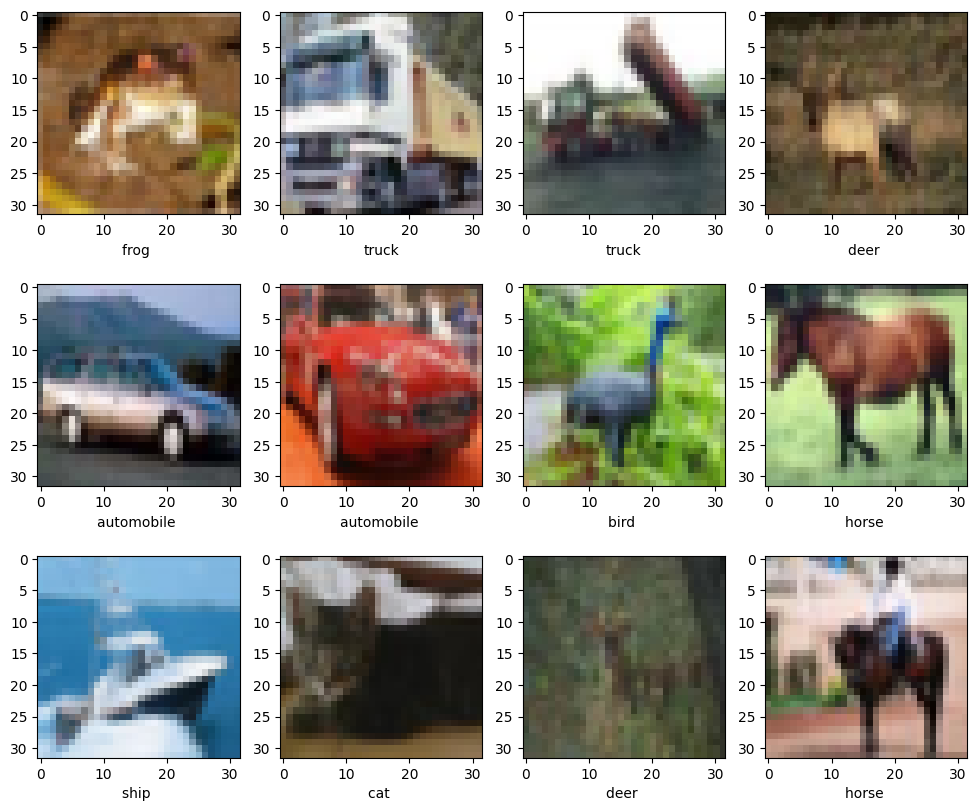

In [7]:
# посмотрим что получилось
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

In [8]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [46]:
X_train.shape

(50000, 32, 32, 3)

In [47]:
dg_x_train.shape

(45000, 32, 32, 3)

In [48]:
dg_y_train.shape

(45000, 1)

In [49]:
dg_x_val.shape

(5000, 32, 32, 3)

In [50]:
dg_y_val.shape

(5000, 1)

In [9]:
# уменьшаем скорость обучения
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                                        factor=0.75,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.00001,
                                        cooldown=2,
                                        min_lr=1e-5
                                       )

In [10]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [29]:
# построим нашу модель
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(32, 32, 3))

# зададим 1-ю цепочку сверточных слоев
way_1 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='valid')(way_1)
way_1 = L.Conv2D(filters=64,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_1)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='valid')(way_1)

# зададим 2-ю цепочку сверточных слоев
way_2 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_2 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='valid')(way_2)
way_2 = L.Conv2D(filters=64,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_2)
way_2 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='valid')(way_2)

"""
# зададим 3-ю цепочку сверточных слоев
way_3 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)
way_3 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(way_3)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)

# зададим 4-ю цепочку сверточных слоев
way_4 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)
way_4 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(way_4)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)
"""
# объединим
#merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.concatenate([way_1, way_2])
merged = L.Flatten()(merged)

# добавим полносвязные слои
out = L.Dense(128, activation='relu')(merged)
#out = L.Dropout(0.2)(out)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
#out = L.Dropout(0.2)(out)
out = L.BatchNormalization()(out)
out = L.Dense(64, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_final_model')

In [25]:
# построим нашу модель
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(32, 32, 3))

# зададим 1-ю цепочку сверточных слоев
way_1 = L.Conv2D(filters=64,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='valid')(way_1)
way_1 = L.Conv2D(filters=128,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_1)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='valid')(way_1)
way_1 = L.Conv2D(filters=256,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_1)
way_1 = L.MaxPooling2D(pool_size=(2, 2),
                       padding='valid')(way_1)

# зададим 2-ю цепочку сверточных слоев
way_2 = L.Conv2D(filters=64,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_2 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='valid')(way_2)
way_2 = L.Conv2D(filters=128,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_2)
way_2 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='valid')(way_2)
way_2 = L.Conv2D(filters=256,
                 kernel_size=(4, 4),
                 padding='valid',
                 strides=(1, 1),
                 activation='relu')(way_2)
way_2 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='valid')(way_2)

"""
# зададим 3-ю цепочку сверточных слоев
way_3 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)
way_3 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 strides=(1, 1),
                 activation='relu')(way_3)
way_3 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_3)

# зададим 4-ю цепочку сверточных слоев
way_4 = L.Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(input_shape)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)
way_4 = L.Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 dilation_rate=(2, 2),
                 strides=(1, 1),
                 activation='relu')(way_4)
way_4 = L.AveragePooling2D(pool_size=(2, 2),
                           padding='same')(way_4)
"""

# объединим
merged = L.concatenate([way_1, way_2])
merged = L.Flatten()(merged)

# добавим полносвязные слои
out = L.Dense(128, activation='relu')(merged)
#out = L.Dropout(0.2)(out)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
#out = L.Dropout(0.2)(out)
out = L.BatchNormalization()(out)
out = L.Dense(80, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(40, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_final_model_2')

In [30]:
# посмотрим на модель
model.summary()

Model: "My_final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate (Concatenate)            │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,354 (1.36 MB)

 Trainable params: 356,650 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
# зададим параметры, скомпилируем и обучим модель
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
batch_size = 16
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=batch_size),
          epochs=epochs,
          callbacks=[reduce_lr],
          validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 571s 201ms/step - loss: 2.1139 - sparse_categorical_accuracy: 0.2268 - val_loss: 2.8228 - val_sparse_categorical_accuracy: 0.1764 - learning_rate: 0.0010
Epoch 2/32
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 568s 202ms/step - loss: 1.7473 - sparse_categorical_accuracy: 0.3624 - val_loss: 1.9836 - val_sparse_categorical_accuracy: 0.3024 - learning_rate: 0.0010
Epoch 3/32
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 570s 202ms/step - loss: 1.7058 - sparse_categorical_accuracy: 0.3757 - val_loss: 1.5376 - val_sparse_categorical_accuracy: 0.4606 - learning_rate: 0.0010
Epoch 4/32
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 575s 205ms/step - loss: 1.5602 - sparse_categorical_accuracy: 0.4407 - val_loss: 2.0096 - val_sparse_categorical_accuracy: 0.3212 - learning_rate: 0.0010
Epoch 5/32
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 576s 205ms/step - loss: 1.5731 - sparse_categorical_accuracy: 0.4323 - val_loss: 1.4277 - val_sparse_categorical_accuracy: 0.4774 - learning_rate: 0.0010
Epoch 6/32
2813/2813

KeyboardInterrupt: 

In [68]:
# проверим
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print('Это победа!')
else:
    print('пичалька)')

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step

 Test_acc = 0.722
пичалька)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [ ]:
## TODO
final_model = tf.keras.models.Sequential([...])

In [ ]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [ ]:
tf.keras.utils.plot_model(final_model, '123.png', show_shapes=True)

In [ ]:
## TODO
final_model.compile(...)
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

AttributeError: 'function' object has no attribute 'predict'

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.